<a href="https://colab.research.google.com/github/AchrafAsh/best-istanbul-datathon/blob/main/exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

- The day-ahead market is the electricity market where the participants are responsible to enter their offers for production and consumption (the amount of electricity to be produced or consumed) and the electricity reference price is formed as a result.

- Day-Ahead Market **transactions are carried out on an hourly basis every day** (each day consists of hourly periods that start at 00:00 and end at 00:00 the next day).

- Every day until 12:30, market participants submit in the day ahead market their day ahead market offers for the next day.

- Confirmed offers are evaluated by the optimization tool between 13:00 and 13:30, and market clearing prices and market clearing amounts for each hour of the relevant day are determined.

- As an electricity producer, our responsibility is to inform the market every day of the electricity volume we will produce hourly for the next day.

- Since the differences between the actual production and the forecasted production we give the day ahead create an imbalance, this imbalance cost is reflected on us.

- For this reason, **forecasting the production as closely as possible maximizes our gain**.


Historical data (facility, turbine locations, realized generation data, measured meteorological data) 


→ Forecast Provider


→ Forecast Data (generation forecast, meteorological forecasts)

## Challenge

- The aim of this use case is forecasting today’s wind power production (**05-06-2021T00:00 – 05-06-2021T23:59**)

- The local forecast of the weather conditions that most affect production greatly affects the forecast quality of production.

- Meteorological-based production forecasting models are built based on detailed inputs such as latitude, longitude, long-term wind speed measured in the region, turbine information.

- The production forecast will be improved by using the weather forecast and production forecasts we received from 3 companies that provide meteorological production forecasts.
---
### Problem
1. meteorological forecast: (latitude, longitude, long-term wind speed, turbine information) → (wind, humidity, temperature, pressure)
2. wind power production forecast: weather, historical data → today forecasted production

### Resources
- Weather and production forecasts of 3 companies

### Output
- 1-day power production forecast on an hourly basis. Should be more accurate than other forecast providers!

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

In [14]:
# dataset paths
path_provider_1 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider1_Usecase2.csv"
path_provider_2 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider2_Usecase2.csv"
path_provider_3 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider3_Usecase2.csv"
path_generation = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/ActualGeneration_Usecase2_v2.csv"

🚨 ProviderID is always **1**

In [15]:
df_provider_1 = pd.read_csv(path_provider_1, sep=";")

In [16]:
df_provider_1

,Datekey,ProviderId,Hour,WindSpeed,WindDirection,Temperature,Pressure,Humidity,PowerWOAvailability
0,20200101,1,00:00,2.0,317.0,5.3,100944,80.57,1.398
1,20200101,1,01:00,1.9,284.0,5.1,100920,79.70,1.992
2,20200101,1,02:00,2.0,270.0,4.8,100895,78.84,2.285
3,20200101,1,03:00,2.2,273.0,4.6,100875,77.98,5.529
4,20200101,1,04:00,2.2,282.0,4.4,100857,75.21,5.284
...,...,...,...,...,...,...,...,...,...
12523,20210605,1,19:00,3.5,12.0,19.0,100454,64.95,8.471
12524,20210605,1,20:00,3.2,15.0,18.3,100546,68.61,6.673
12525,20210605,1,21:00,2.9,21.0,17.5,100544,72.26,5.775
12526,20210605,1,22:00,2.7,32.0,16.9,100547,72.88,4.913


In [17]:
# change column names
df_provider_1.rename(columns={ "Datekey": "date",
                              "ProviderId": "provider_id",
                              "Hour": "hour",
                              "WindSpeed": "wind_speed",
                              "WindDirection": "wind_direction",
                              "Temperature": "temperature",
                              "Pressure": "pressure",
                              "Humidity": "humidity",
                              "PowerWOAvailability": "power_wo_availability"},
                     inplace=True)

df_provider_1

,date,provider_id,hour,wind_speed,wind_direction,temperature,pressure,humidity,power_wo_availability
0,20200101,1,00:00,2.0,317.0,5.3,100944,80.57,1.398
1,20200101,1,01:00,1.9,284.0,5.1,100920,79.70,1.992
2,20200101,1,02:00,2.0,270.0,4.8,100895,78.84,2.285
3,20200101,1,03:00,2.2,273.0,4.6,100875,77.98,5.529
4,20200101,1,04:00,2.2,282.0,4.4,100857,75.21,5.284
...,...,...,...,...,...,...,...,...,...
12523,20210605,1,19:00,3.5,12.0,19.0,100454,64.95,8.471
12524,20210605,1,20:00,3.2,15.0,18.3,100546,68.61,6.673
12525,20210605,1,21:00,2.9,21.0,17.5,100544,72.26,5.775
12526,20210605,1,22:00,2.7,32.0,16.9,100547,72.88,4.913


In [31]:
# format date
def format_date(date:int):
    date_string = str(date)
    year = date_string[:4]
    month = date_string[4:6]
    day = date_string[6:]
    # convert to datetime
    return f"{year}-{month}-{day}"

df_provider_1["date"] = df_provider_1["date"].apply(format_date)

In [33]:
# bring date and hour together
df_provider_1["date"] = df_provider_1["date"] + "T" + df_provider_1["hour"] + ":00"

In [35]:
# drop hour column
df_provider_1.drop(columns=["hour"], inplace=True)

In [38]:
# set the date to index
df_provider_1.set_index("date", inplace=True)

In [40]:
df_provider_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12528 entries, 2020-01-01T00:00:00 to 2021-06-05T23:00:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   provider_id            12528 non-null  int64  
 1   wind_speed             12528 non-null  float64
 2   wind_direction         12528 non-null  float64
 3   temperature            12528 non-null  float64
 4   pressure               12528 non-null  int64  
 5   humidity               12528 non-null  float64
 6   power_wo_availability  12528 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 783.0+ KB


In [41]:
df_provider_1.describe()

,provider_id,wind_speed,wind_direction,temperature,pressure,humidity,power_wo_availability
count,12528.0,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000
mean,1.0,5.210672,122.664671,14.132830,100115.943726,71.891239,21.937733
std,0.0,3.053338,105.586050,7.066683,676.171578,10.434038,18.559513
min,1.0,0.500000,0.000000,-3.900000,97614.000000,33.830000,0.000000
25%,1.0,2.600000,33.000000,8.500000,99628.000000,64.660000,4.183750
50%,1.0,4.600000,66.000000,13.200000,100059.000000,72.060000,16.245000
75%,1.0,7.300000,203.000000,20.300000,100545.000000,79.412500,40.927000
max,1.0,18.500000,360.000000,31.200000,102650.000000,98.100000,55.013000


# Data Processing

In [155]:
def get_provider_data(path: str):
    df_provider = pd.read_csv(path, sep=";")
    # change column names
    df_provider.rename(columns={ "Datekey": "date",
                                "ProviderId": "provider_id",
                                "Hour": "hour",
                                "WindSpeed": "wind_speed",
                                "WindDirection": "wind_direction",
                                "Temperature": "temperature",
                                "Pressure": "pressure",
                                "Humidity": "humidity",
                                "PowerWOAvailability": "power"},
                        inplace=True)
    # format date
    df_provider["date"] = df_provider["date"].apply(format_date)
    # aggregate date and hour
    df_provider["date"] = df_provider["date"] + "T" + df_provider["hour"]
    # convert to datetime object
    df_provider["date"] = df_provider.date.apply(
        lambda d: datetime.strptime(d,"%Y-%m-%dT%H:%M")
        )
    # drop hour column
    df_provider.drop(columns=["hour"], inplace=True)
    return df_provider

In [225]:
def average_forecasts(*list_of_providers):
    
    # Meteorological data 
    
    provider_1 = list_of_providers[0]
    provider_2 = list_of_providers[1]
    provider_3 = list_of_providers[2]
    
    provider_final_df = pd.DataFrame(index = list(provider_1.index), columns = list(provider_1.columns))
    
    provider_final_df.date = provider_1.date
    
    del provider_final_df['provider_id']
    
    for column in list(provider_final_df.columns):
        
        if column != 'date':
        
            to_average = pd.DataFrame() 
            to_average[column+'_1'] = provider_1[column]
            to_average[column+'_2'] = provider_2[column]
            to_average[column+'_3'] = provider_3[column]

            provider_final_df[column] = to_average.mean(axis = 1)
    
    return(provider_final_df)

In [227]:
avg_forecasts = average_forecasts(provider_1, provider_2, provider_3)

# Exploratory Data Analysis

In [105]:
provider_1 = get_provider_data(path_provider_1)
provider_2 = get_provider_data(path_provider_2)
provider_3 = get_provider_data(path_provider_3)

In [67]:
provider_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12528 non-null  datetime64[ns]
 1   provider_id            12528 non-null  int64         
 2   wind_speed             12528 non-null  float64       
 3   wind_direction         12528 non-null  float64       
 4   temperature            12528 non-null  float64       
 5   pressure               12528 non-null  int64         
 6   humidity               12528 non-null  float64       
 7   power_wo_availability  12528 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 783.1 KB


`provider_1` has no null values to handle

In [94]:
provider_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12528 non-null  datetime64[ns]
 1   provider_id            12528 non-null  int64         
 2   wind_speed             11472 non-null  float64       
 3   wind_direction         11472 non-null  float64       
 4   temperature            11472 non-null  float64       
 5   pressure               11472 non-null  float64       
 6   humidity               11472 non-null  float64       
 7   power_wo_availability  12432 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 783.1 KB


`provider_2` has some null values everywhere

In [95]:
provider_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12528 non-null  datetime64[ns]
 1   provider_id            12528 non-null  int64         
 2   wind_speed             12504 non-null  float64       
 3   wind_direction         12504 non-null  float64       
 4   temperature            12504 non-null  float64       
 5   pressure               11496 non-null  float64       
 6   humidity               11496 non-null  float64       
 7   power_wo_availability  12504 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 783.1 KB


`provider_3` has also some null values on every column

In [51]:
actual_generation = pd.read_csv(path_generation, sep=";", parse_dates=["PCTimeStamp"])
actual_generation.rename(columns={"PCTimeStamp": "date",
                                  "PowerMWh": "power"},
                         inplace=True)
actual_generation

,date,power
0,2020-01-01 00:00:00,3.364000
1,2020-01-01 01:00:00,1.606000
2,2020-01-01 02:00:00,2.808000
3,2020-01-01 03:00:00,2.543000
4,2020-01-01 04:00:00,0.093000
...,...,...
12499,2021-06-04 19:00:00,5.052000
12500,2021-06-04 20:00:00,6.013000
12501,2021-06-04 21:00:00,4.372000
12502,2021-06-04 22:00:00,3.007326


In [52]:
actual_generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12504 entries, 0 to 12503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    12504 non-null  datetime64[ns]
 1   power   12442 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 195.5 KB


[Text(0.5, 1.0, 'Forecasted and actual production (7 days)')]

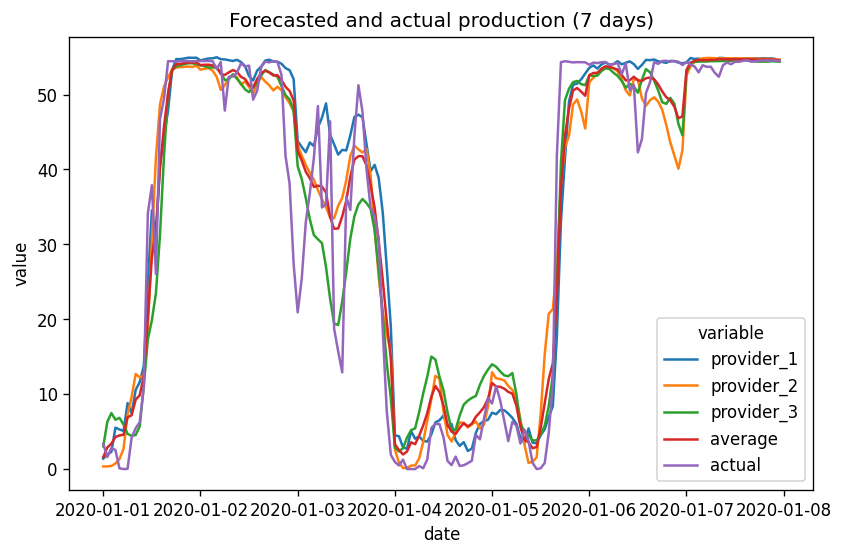

In [229]:
# visualize forecasted and actual productions
data = pd.DataFrame({
    "date": actual_generation.date[:168],
    "provider_1": provider_1[:168]["power"],
    "provider_2": provider_2[:168]["power"],
    "provider_3": provider_3[:168]["power"],
    "average": avg_forecasts[:168]["power"],
    "actual": actual_generation["power"],
})

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(data, ["date"])).set(title="Forecasted and actual production (7 days)")

## Evaluating the providers' forecasts

In [236]:
# handling actual generation values
# nans
actual_generation.power = actual_generation.power.fillna(method="ffill")
# inf values
actual_generation.power = actual_generation.power.replace(float("inf"), value=max(avg_forecasts.power))

In [239]:
np.sum((actual_generation.power - avg_forecasts.power)**2)

955532.0134014146

In [247]:
split_idx = 12336
len(provider_1)

12528